Samples: 529, Traits: ['Yield', 'Plant_height', 'Grain_weight'], Simulating 5000 SNPs...

Running GWAS for trait: Yield
Bonferroni threshold (−log10): 5.00
Saved GWAS table to: D:\College\BE\Outputs\BI\BI6\PracticalResults\gwas_Yield.csv


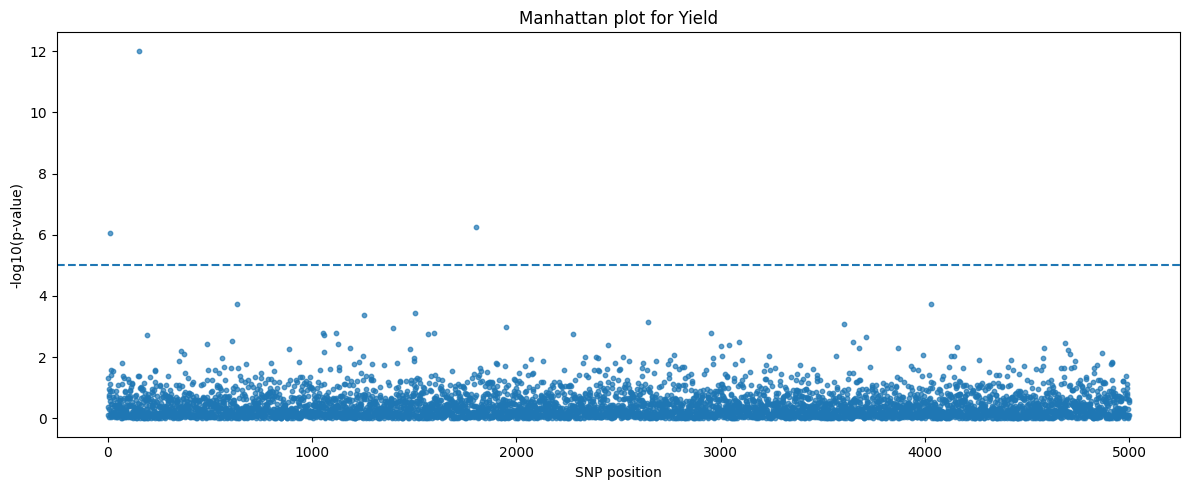

Significant SNPs: 3  (saved to D:\College\BE\Outputs\BI\BI6\PracticalResults\significant_snps_Yield.csv)

Running GWAS for trait: Plant_height
Bonferroni threshold (−log10): 5.00
Saved GWAS table to: D:\College\BE\Outputs\BI\BI6\PracticalResults\gwas_Plant_height.csv


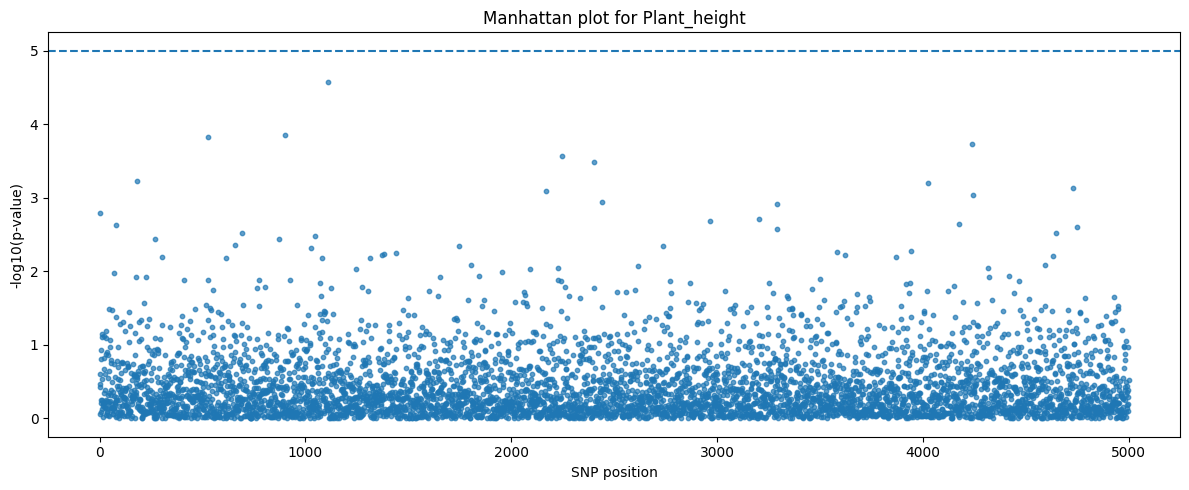

Significant SNPs: 0  (saved to D:\College\BE\Outputs\BI\BI6\PracticalResults\significant_snps_Plant_height.csv)

Running GWAS for trait: Grain_weight
Bonferroni threshold (−log10): 5.00
Saved GWAS table to: D:\College\BE\Outputs\BI\BI6\PracticalResults\gwas_Grain_weight.csv


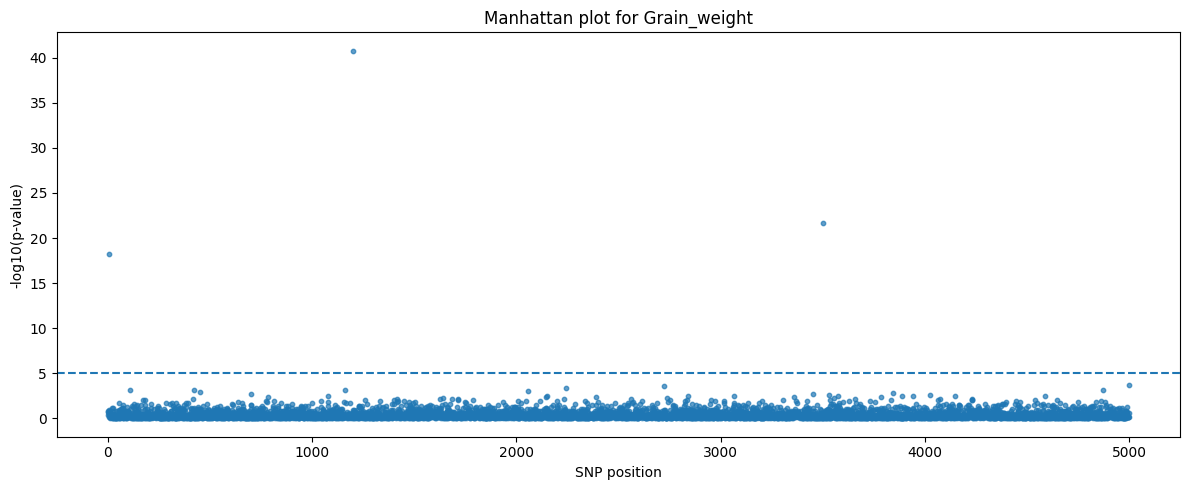

Significant SNPs: 3  (saved to D:\College\BE\Outputs\BI\BI6\PracticalResults\significant_snps_Grain_weight.csv)

Combined significant SNPs saved to: D:\College\BE\Outputs\BI\BI6\PracticalResults\combined_significant_snps.csv

All results saved to folder: D:\College\BE\Outputs\BI\BI6\PracticalResults


In [1]:
# Requirements (install if needed):
# pip install pandas numpy statsmodels matplotlib

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import os

# ---------- Config ----------
PHENOS_PATH = r"D:\College\BE\Outputs\BI\BI6\phenos.csv"      # input phenotypes file
OUT_DIR = r"D:\College\BE\Outputs\BI\BI6\PracticalResults"
N_SNPS = 5000                             # number of simulated SNPs
TRAITS = ["Yield", "Plant_height", "Grain_weight"]  # traits to analyze
np.random.seed(42)
# ----------------------------

os.makedirs(OUT_DIR, exist_ok=True)

# Load phenotype data
phenos = pd.read_csv(PHENOS_PATH).reset_index(drop=True)

# Check traits exist
for t in TRAITS:
    if t not in phenos.columns:
        raise ValueError(f"Trait '{t}' not found in phenos.csv. Columns: {phenos.columns.tolist()}")

n_samples = phenos.shape[0]
print(f"Samples: {n_samples}, Traits: {TRAITS}, Simulating {N_SNPS} SNPs...")

# Simulate SNP matrix (0,1,2) — rows = samples, cols = SNPs
G = pd.DataFrame(
    np.random.randint(0, 3, size=(n_samples, N_SNPS)),
    columns=[f"SNP_{i+1}" for i in range(N_SNPS)]
)

# Specify causal SNP indices for demonstration (0-based indices)
causal_snps_for_trait = {
    "Yield": [10, 150, 1800],
    "Plant_height": [50, 900, 2400],
    "Grain_weight": [5, 1200, 3500]
}
effect_sizes = [3.5, 5.0, 4.0]  # effect sizes to inject (one per causal SNP)

# Create simulated phenotypes by adding genetic effects onto real phenotypes
phenotype_sim = {}
for trait in TRAITS:
    base = phenos[trait].astype(float).copy()
    for i, s in enumerate(causal_snps_for_trait.get(trait, [])):
        base = base + G.iloc[:, s] * effect_sizes[i]
    phenotype_sim[trait] = base


def run_gwas(trait_series, G_df):
    results = []
    
    for snp in G_df.columns:
        X = sm.add_constant(G_df[snp])           # intercept + SNP
        model = sm.OLS(trait_series, X).fit()
        pval = model.pvalues.get(snp, np.nan)
        results.append((snp, pval))
    gwas_df = pd.DataFrame(results, columns=["SNP", "p"])
    gwas_df["-log10(p)"] = -np.log10(gwas_df["p"])
    gwas_df["Pos"] = range(len(gwas_df))
    return gwas_df


all_significant = {}
for trait in TRAITS:
    print(f"\nRunning GWAS for trait: {trait}")
    trait_series = phenotype_sim[trait]
    gwas_df = run_gwas(trait_series, G)
    
    threshold = -np.log10(0.05 / N_SNPS)
    print(f"Bonferroni threshold (−log10): {threshold:.2f}")

    # Save GWAS table
    gwas_csv = os.path.join(OUT_DIR, f"gwas_{trait}.csv")
    gwas_df.to_csv(gwas_csv, index=False)
    print(f"Saved GWAS table to: {gwas_csv}")

    # Plot Manhattan plot interactively
    plt.figure(figsize=(12,5))
    plt.scatter(gwas_df["Pos"], gwas_df["-log10(p)"], s=10, alpha=0.7)
    plt.axhline(threshold, linestyle="--")
    plt.title(f"Manhattan plot for {trait}")
    plt.xlabel("SNP position")
    plt.ylabel("-log10(p-value)")
    plt.tight_layout()
    plt.show()

    # Save significant SNPs
    sig = gwas_df[gwas_df["-log10(p)"] > threshold].copy().sort_values("-log10(p)", ascending=False)
    sig_csv = os.path.join(OUT_DIR, f"significant_snps_{trait}.csv")
    sig.to_csv(sig_csv, index=False)
    all_significant[trait] = sig
    print(f"Significant SNPs: {len(sig)}  (saved to {sig_csv})")


# Combine top significant SNPs across traits
combined_list = []
for trait, df in all_significant.items():
    if not df.empty:
        top = df.head(50).copy()
        top["Trait"] = trait
        combined_list.append(top[["Trait","SNP","p","-log10(p)","Pos"]])
if combined_list:
    combined_df = pd.concat(combined_list, ignore_index=True)
    combined_csv = os.path.join(OUT_DIR, "combined_significant_snps.csv")
    combined_df.to_csv(combined_csv, index=False)
    print(f"\nCombined significant SNPs saved to: {combined_csv}")
else:
    print("\nNo significant SNPs across analyzed traits.")

print(f"\nAll results saved to folder: {OUT_DIR}")